In [1]:
import math

import matplotlib.pyplot as plt
import itertools as it
from modelbase.ode import Simulator

from src import (
    Rate,
    Moiety,
    invert_stoichiometries,
    flatten,
    stringify_nested_list,
    unpack_stoichiometries,
    generate_all_substrates,
    create_rate_function,
    create_rate_function_name,
    get_compounds_by_suffix,
    create_stoichiometries,
    generate_reaction_parameter_names,
    get_fcd,
    get_model,
    get_rates,
    get_rhs,
    generate_rates,
    generate_moieties,
    head,
    to_modelbase,
)

# Manual definitions

In [2]:
base_compounds = [f"C{i}" for i in range(4, 18, 2)]
base_suffixes = [
    "AcylCoACyt",
    "AcylCarCyt",
    "AcylCarMat",
    "AcylCoAMat",
    "EnoylCoAMat",
    "HydroxyacylCoAMat",
    "KetoacylCoAMat",
]

substrate_enzymes = {
    "AcylCoACyt": ["cpt1"],
    "AcylCarCyt": ["cact"],
    "AcylCarMat": ["cpt2"],
    "AcylCoAMat": ["vlcad", "lcad", "mcad", "scad"],
    "EnoylCoAMat": ["crot", "mtp"],
    "HydroxyacylCoAMat": ["mschad"],
    "KetoacylCoAMat": ["mckat"],
}
enzyme_products = {
    "cpt1": "AcylCarCyt",
    "cact": "AcylCarMat",
    "cpt2": "AcylCoAMat",
    "vlcad": "EnoylCoAMat",
    "lcad": "EnoylCoAMat",
    "mcad": "EnoylCoAMat",
    "scad": "EnoylCoAMat",
    "crot": "HydroxyacylCoAMat",
    "mschad": "KetoacylCoAMat",
    "mckat": "AcylCoAMat",
    "mtp": "AcylCoAMat",
}

allowed_substrates = {
    "vlcad": ["C12", "C14", "C16"],
    "lcad": ["C8", "C10", "C12", "C14", "C16"],
    "mcad": ["C4", "C8", "C10", "C12"],
    "scad": ["C4", "C6"],
    "mtp": ["C8", "C10", "C12", "C14", "C16"],
}

no_sf = ["cact"]

forbidden_substrates = {}
for k, v in allowed_substrates.items():
    forbidden_substrates[k] = [i for i in base_compounds if i not in v]

# Generate model

In [3]:
all_compounds = flatten(
    generate_all_substrates(
        substrates=base_compounds,
        base_suffixes=base_suffixes,
    )
)
all_compounds[:5]

['C4_AcylCoACyt',
 'C4_AcylCarCyt',
 'C4_AcylCarMat',
 'C4_AcylCoAMat',
 'C4_EnoylCoAMat']

In [4]:
stoichiometries = create_stoichiometries(
    all_compounds=all_compounds,
    substrate_enzymes=substrate_enzymes,
    enzyme_products=enzyme_products,
    forbidden_substrates=forbidden_substrates,
)

head(stoichiometries, 5)

{'vcpt1_C4': {'C4_AcylCoACyt': -1.0, 'C4_AcylCarCyt': 1.0},
 'vcact_C4': {'C4_AcylCarCyt': -1.0, 'C4_AcylCarMat': 1.0},
 'vcpt2_C4': {'C4_AcylCarMat': -1.0, 'C4_AcylCoAMat': 1.0},
 'vmcad_C4': {'C4_AcylCoAMat': -1.0, 'C4_EnoylCoAMat': 1.0},
 'vscad_C4': {'C4_AcylCoAMat': -1.0, 'C4_EnoylCoAMat': 1.0}}

In [5]:
cpds_by_suffix = get_compounds_by_suffix(all_compounds)

head(cpds_by_suffix, 2)

{'AcylCoACyt': ['C4_AcylCoACyt',
  'C6_AcylCoACyt',
  'C8_AcylCoACyt',
  'C10_AcylCoACyt',
  'C12_AcylCoACyt',
  'C14_AcylCoACyt',
  'C16_AcylCoACyt'],
 'AcylCarCyt': ['C4_AcylCarCyt',
  'C6_AcylCarCyt',
  'C8_AcylCarCyt',
  'C10_AcylCarCyt',
  'C12_AcylCarCyt',
  'C14_AcylCarCyt',
  'C16_AcylCarCyt']}

In [6]:
print(
    create_rate_function(
        n_substrate_cofactors=1,  # 2
        n_product_cofactors=1,  # 2
        n_substrate_competitors=1,  # 8
        n_product_competitors=1,  # 8
        n_inhibitors=1,  # 1
    )
)

def enzyme_1scf_1pcf_1scp_1pcp_1i(
    s1,
    p1,
    scf_1,
    spf_1,
    scp_1,
    pcp_1,
    i_1,
    vmax,
    sf,
    keq,
    km_s1,
    km_p1,
    km_scf_1,
    km_spf_1,
    km_scp_1,
    km_pcp_1,
    ki_1
):
    
    numerator = vmax * sf * (s1 / km_s1 - p1 / (km_p1 * keq))
    denominator = (1 + (s1 / km_s1 + p1 / km_p1 + scp_1 / km_scp_1 + pcp_1 / km_pcp_1 + i_1 / ki_1)) * (scf_1 / km_scf_1 + scf_1 / km_scf_1)
    return numerator / denominator
    



In [7]:
with open("src/generated_functions.py", "w") as f:
    f.write("# type: ignore\n\n")
    for n_substrate_cof in range(2 + 1):
        for n_product_cof in range(2 + 1):
            for n_substrate_cop in range(8 + 1):
                for n_product_cop in range(8 + 1):
                    for n_inhibitors in range(1 + 1):
                        f.write(
                            create_rate_function(
                                n_substrate_cofactors=n_substrate_cof,
                                n_product_cofactors=n_product_cof,
                                n_substrate_competitors=n_substrate_cop,
                                n_product_competitors=n_product_cop,
                                n_inhibitors=n_inhibitors,
                            )
                        )
                        f.write("\n")

In [8]:
import src.generated_functions as gen

In [9]:
functions = {name: getattr(gen, name) for name in dir(gen) if not name.startswith("__")}

In [10]:
rates = generate_rates(
    functions=functions,
    cpds_by_suffix=cpds_by_suffix,
    stoichiometries_by_rate=stoichiometries,
    inhibitors={},
    cofactors={},
)
print(rates["vcpt1_C4"].func)
print(rates["vcpt1_C4"].substrates[:3])
print(rates["vcpt1_C4"].products[:3])
print(rates["vcpt1_C4"].modifiers[:3])
print(rates["vcpt1_C4"].parameters[:3])
print(rates["vcpt1_C4"].args[:3])
print(rates["vcpt1_C4"].reversible)

# rates["vcpt1_C4"]

<function enzyme_0scf_0pcf_7scp_7pcp_0i at 0x7fb5d6900160>
['C4_AcylCoACyt']
['C4_AcylCarCyt']
['C4_AcylCoACyt', 'C6_AcylCoACyt', 'C8_AcylCoACyt']
['vmax_cpt1', 'sf_cpt1_C4_AcylCoACyt', 'keq_cpt1']
['C4_AcylCoACyt', 'C4_AcylCarCyt', 'C4_AcylCoACyt']
True


In [11]:
parameters = {}
for rate in rates.values():
    parameters.update(dict(zip(rate.parameters, it.repeat(1))))

In [12]:
moieties = {}

In [13]:
m = to_modelbase(
    compounds=all_compounds,
    parameters=parameters,
    moieties=moieties,
    rates=rates,
    stoichiometries=stoichiometries,
)

In [14]:
y0 = dict(zip(m.compounds, it.repeat(0)))
y0["C4_AcylCoACyt"] = 1

In [15]:
head(m.get_full_concentration_dict(y0), 5)

{'C4_AcylCoACyt': array([1.]),
 'C4_AcylCarCyt': array([0.]),
 'C4_AcylCarMat': array([0.]),
 'C4_AcylCoAMat': array([0.]),
 'C4_EnoylCoAMat': array([0.])}

In [16]:
head(m.get_fluxes_dict(y0), 5)

{'vcpt1_C4': array([0.33333333]),
 'vcact_C4': array([0.]),
 'vcpt2_C4': array([0.]),
 'vmcad_C4': array([0.]),
 'vscad_C4': array([0.])}

In [17]:
head(m.get_right_hand_side(y0), 5)

{'dC4_AcylCoACytdt': -0.3333333333333333,
 'dC4_AcylCarCytdt': 0.3333333333333333,
 'dC4_AcylCarMatdt': 0.0,
 'dC4_AcylCoAMatdt': 0.0,
 'dC4_EnoylCoAMatdt': 0.0}

In [18]:
groups = [m.compounds[4 * i : 4 * i + 4] for i in range(math.ceil(len(m.compounds) / 4))]

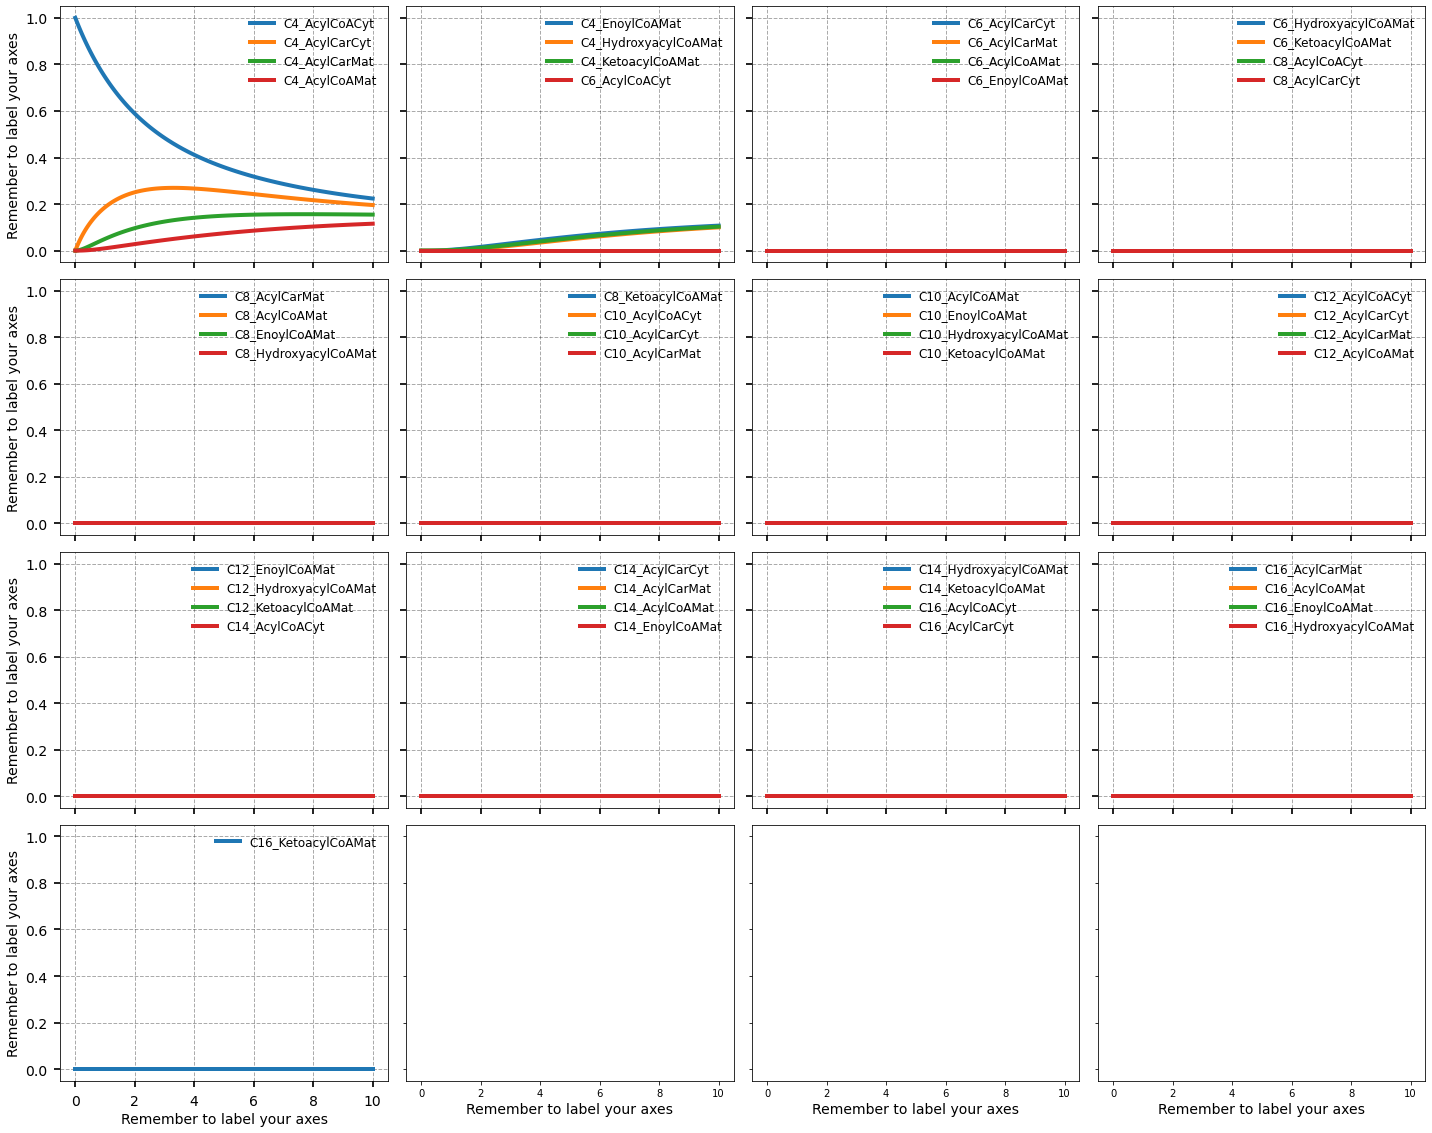

In [19]:
s = Simulator(m)
s.initialise(y0)
s.simulate(10)


fig, ax = s.plot_grid(groups, ncols=4)
plt.show()